In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow import math
from catboost import CatBoostRegressor

In [2]:
data = pd.read_csv('data/preprocessed_data.csv')
data.head(5)

,User-ID,Book-Rating,Book-Author,Year-Of-Publication,Location,Age,raw_title,categories
0,2313,7,raybradbury,1984.0,usa,23.0,themartianchronicles,fiction
1,2313,8,johnokada,1978.0,usa,23.0,nonoboy,japanese
2,6543,8,raybradbury,1976.0,usa,34.0,fahrenheit451,bookburning
3,6543,9,jamespatterson,2001.0,usa,34.0,1sttodieanovel,fiction
4,6543,6,alexandermccallsmith,2002.0,usa,34.0,theno1ladiesdetectiveagency,botswana


In [3]:
embedded_data = data[['User-ID', 'raw_title', 'Book-Rating']]
embedded_data['Book-Rating'] = embedded_data['Book-Rating'].astype(float)
embedded_data.head(5)

C:\Users\79237\AppData\Local\Temp\ipykernel_8552\1623552856.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedded_data['Book-Rating'] = embedded_data['Book-Rating'].astype(float)


,User-ID,raw_title,Book-Rating
0,2313,themartianchronicles,7.0
1,2313,nonoboy,8.0
2,6543,fahrenheit451,8.0
3,6543,1sttodieanovel,9.0
4,6543,theno1ladiesdetectiveagency,6.0


In [4]:
label_encoder = LabelEncoder()
embedded_data['raw_title'] = label_encoder.fit_transform(embedded_data['raw_title'])
embedded_data = embedded_data.rename(columns={'User-ID': 'user-id', 'raw_title': 'book-id', 'Book-Rating': 'rating'})
embedded_data.head(5)

C:\Users\79237\AppData\Local\Temp\ipykernel_8552\3648230060.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embedded_data['raw_title'] = label_encoder.fit_transform(embedded_data['raw_title'])


,user-id,book-id,rating
0,2313,11266,7.0
1,2313,7036,8.0
2,6543,3469,8.0
3,6543,39,9.0
4,6543,11466,6.0


In [5]:
X_embedded = embedded_data[['user-id', 'book-id']]
y_embedded = embedded_data['rating']

In [6]:
all_users = X_embedded['user-id'].unique()
all_books = X_embedded['book-id'].unique()

In [7]:
user_input = keras.layers.Input(shape=(1,), name="User")
user_as_integer = keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = keras.layers.Embedding(input_dim=len(all_users) + 1, output_dim=32, embeddings_regularizer=keras.regularizers.l2(0.1), name="user-embedding")(user_as_integer)

In [8]:
book_input = keras.layers.Input(shape=(1,), name="Book")
book_as_integer = keras.layers.IntegerLookup(vocabulary=all_books)(book_input)
book_embedding = keras.layers.Embedding(input_dim=len(all_books) + 1, output_dim=32, embeddings_regularizer=keras.regularizers.l2(0.1), name="book-embedding")(book_as_integer)

In [9]:
dot_product = keras.layers.Dot(axes=-1)([user_embedding, book_embedding])
flatten = keras.layers.Flatten()(dot_product)

In [10]:
output = keras.layers.Lambda(lambda x: 9 * math.sigmoid(x) + 1, name="Rating")(flatten)

In [11]:
model = keras.Model(inputs=[user_input, book_input], outputs=output)
model.compile(loss="mse", metrics=[keras.metrics.RootMeanSquaredError])

In [12]:
model.fit(x=[X_embedded['user-id'], X_embedded['book-id']], y=y_embedded, batch_size=256, epochs=40, validation_split=0.1)

Epoch 1/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 22.8877 - root_mean_squared_error: 2.8456 - val_loss: 7.6130 - val_root_mean_squared_error: 2.7535
Epoch 2/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.1193 - root_mean_squared_error: 2.8494 - val_loss: 7.6130 - val_root_mean_squared_error: 2.7535
Epoch 3/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.1213 - root_mean_squared_error: 2.8498 - val_loss: 7.6130 - val_root_mean_squared_error: 2.7535
Epoch 4/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.0986 - root_mean_squared_error: 2.8458 - val_loss: 7.6130 - val_root_mean_squared_error: 2.7535
Epoch 5/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.1282 - root_mean_squared_error: 2.8510 - val_loss: 7.6130 - val_root_mean_squared_error: 2.7535
Epoch 6/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 8.1160 - root_mean_squared_error: 2.8488 - val_loss: 7.6130 - val_root_mean_squared_error: 2.7535
Epoch 7/40
245/245 ━━━━━━━━━━━━━━━━━━━━ 3s 11

In [17]:
embedded_user_output = model.get_layer("user-embedding").output
embedded_book_output = model.get_layer("book-embedding").output
embedding_user_model = keras.Model(inputs=[user_input, book_input], outputs=embedded_user_output)
embedding_book_model = keras.Model(inputs=[user_input, book_input], outputs=embedded_book_output)

In [18]:
user_feature = embedding_user_model.predict(x=[X_embedded['user-id'], X_embedded['book-id']]).reshape((69659, 32)).tolist()
user_df = pd.DataFrame(user_feature)
user_df = user_df.add_suffix('_user')
book_feature = embedding_book_model.predict(x=[X_embedded['user-id'], X_embedded['book-id']]).reshape((69659, 32)).tolist()
book_df = pd.DataFrame(book_feature)
book_df = book_df.add_suffix('_book')

2177/2177 ━━━━━━━━━━━━━━━━━━━━ 2s 819us/step
2177/2177 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step


In [15]:
data = data.drop(columns=['User-ID', 'raw_title'])
data.head(5)

,Book-Rating,Book-Author,Year-Of-Publication,Location,Age,categories
0,7,raybradbury,1984.0,usa,23.0,fiction
1,8,johnokada,1978.0,usa,23.0,japanese
2,8,raybradbury,1976.0,usa,34.0,bookburning
3,9,jamespatterson,2001.0,usa,34.0,fiction
4,6,alexandermccallsmith,2002.0,usa,34.0,botswana


In [16]:
data = pd.concat([data, user_df, book_df], axis=1)
data.head(5)

,Book-Rating,Book-Author,Year-Of-Publication,Location,Age,categories,0_user,1_user,2_user,3_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,7,raybradbury,1984.0,usa,23.0,fiction,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,...,-1.447275e-35,-2.999835e-35,-2.465072e-35,-1.243177e-35,3.271923e-35,-2.446234e-35,-2.716465e-36,5.414116e-36,-3.874901e-36,-8.408619e-36
1,8,johnokada,1978.0,usa,23.0,japanese,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,...,2.491273e-35,-2.262973e-35,3.601540e-35,-2.430414e-35,3.876107e-35,-2.552233e-35,3.668902e-35,4.996898e-35,4.552321e-35,-2.883939e-35
2,8,raybradbury,1976.0,usa,34.0,bookburning,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,...,9.727600e-36,1.468088e-35,1.281101e-35,2.338744e-35,-9.351827e-36,-1.370909e-36,-5.498857e-36,2.693176e-36,-1.564115e-35,6.253389e-36
3,9,jamespatterson,2001.0,usa,34.0,fiction,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,...,-1.325158e-35,-9.506196e-36,-1.141113e-35,2.076580e-35,9.893831e-36,-3.054702e-35,9.348819e-36,9.954250e-37,2.606136e-36,1.546924e-35
4,6,alexandermccallsmith,2002.0,usa,34.0,botswana,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,...,-5.187136e-36,1.095944e-35,-1.390311e-35,1.905214e-35,-3.152757e-35,1.556740e-35,1.291411e-35,-1.203573e-35,2.688625e-35,-3.427981e-35


### Заполнение пропусков

In [19]:
data.isna().sum()

Book-Rating                0
Book-Author                0
Year-Of-Publication       38
Location                   0
Age                    21675
                       ...  
27_book                    0
28_book                    0
29_book                    0
30_book                    0
31_book                    0
Length: 70, dtype: int64

In [20]:
data['Year-Of-Publication'] = data['Year-Of-Publication'].fillna(data['Year-Of-Publication'].median())

<Axes: xlabel='Age', ylabel='Count'>

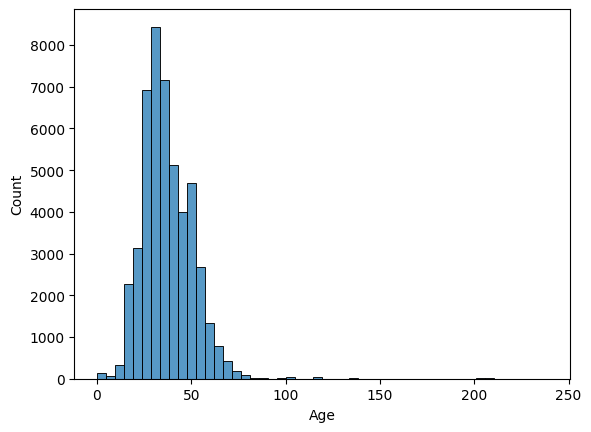

In [21]:
sns.histplot(data['Age'], bins=50)

In [22]:
data['Age'] = np.where((data['Age'] > 10) & (data['Age'] < 100), data['Age'], np.nan)

In [23]:
miss_data = data.drop(columns=['Book-Rating', 'Book-Author', 'Location', 'categories'])
miss_data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,1984.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,-1.447275e-35,-2.999835e-35,-2.465072e-35,-1.243177e-35,3.271923e-35,-2.446234e-35,-2.716465e-36,5.414116e-36,-3.874901e-36,-8.408619e-36
1,1978.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,2.491273e-35,-2.262973e-35,3.601540e-35,-2.430414e-35,3.876107e-35,-2.552233e-35,3.668902e-35,4.996898e-35,4.552321e-35,-2.883939e-35
2,1976.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,9.727600e-36,1.468088e-35,1.281101e-35,2.338744e-35,-9.351827e-36,-1.370909e-36,-5.498857e-36,2.693176e-36,-1.564115e-35,6.253389e-36
3,2001.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-1.325158e-35,-9.506196e-36,-1.141113e-35,2.076580e-35,9.893831e-36,-3.054702e-35,9.348819e-36,9.954250e-37,2.606136e-36,1.546924e-35
4,2002.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-5.187136e-36,1.095944e-35,-1.390311e-35,1.905214e-35,-3.152757e-35,1.556740e-35,1.291411e-35,-1.203573e-35,2.688625e-35,-3.427981e-35


In [24]:
scaler = StandardScaler()
miss_data = pd.DataFrame(scaler.fit_transform(miss_data), columns=miss_data.columns)
miss_data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,-0.670241,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,-0.355870,-1.117376,-0.925838,-0.449625,1.198366,-0.736501,-0.054762,0.217091,-0.114210,-0.168711
1,-1.207090,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,1.087220,-0.845408,1.291691,-0.882824,1.418502,-0.775613,1.382938,1.846833,1.689526,-0.913771
2,-1.386040,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,0.530835,0.531685,0.443501,0.857346,-0.334507,0.115533,-0.156277,0.117564,-0.543846,0.365977
3,0.850831,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.311126,-0.361033,-0.441891,0.761688,0.366715,-0.961015,0.385437,0.055463,0.122441,0.702056
4,0.940306,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.015643,0.394331,-0.532980,0.699160,-1.142487,0.740528,0.515516,-0.421194,1.009011,-1.112170


In [26]:
miss_test = miss_data[miss_data['Age'].isna()]
miss_test.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
33,-1.028141,NaN,-0.981202,-1.107202,-1.286672,1.74022,-1.269245,1.343026,-1.373715,-0.880547,...,0.210104,0.171603,1.100042,0.460586,0.559582,-0.077043,0.820937,0.707939,-0.799509,0.317018
34,-2.817638,NaN,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,-0.369061,-0.331154,0.201876,-0.191199,0.770103,0.119182,0.803180,0.511435,-0.056080,-0.343900
35,0.224507,NaN,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,0.568963,-0.827255,0.091003,-1.181300,1.359110,-0.105461,-0.892260,0.381304,-0.986227,-0.657761
36,0.582407,NaN,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,0.174414,0.670755,0.541148,-0.314269,-0.795365,1.025505,-0.245870,-0.132693,0.133738,-0.807537
37,0.761356,NaN,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,0.241148,0.453760,-0.529350,-0.281500,-0.125705,0.222294,-0.425827,0.550333,-0.407639,0.170210


In [28]:
miss_train = miss_data.dropna()
miss_train.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,-0.670241,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,-0.355870,-1.117376,-0.925838,-0.449625,1.198366,-0.736501,-0.054762,0.217091,-0.114210,-0.168711
1,-1.207090,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,1.087220,-0.845408,1.291691,-0.882824,1.418502,-0.775613,1.382938,1.846833,1.689526,-0.913771
2,-1.386040,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,0.530835,0.531685,0.443501,0.857346,-0.334507,0.115533,-0.156277,0.117564,-0.543846,0.365977
3,0.850831,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.311126,-0.361033,-0.441891,0.761688,0.366715,-0.961015,0.385437,0.055463,0.122441,0.702056
4,0.940306,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.015643,0.394331,-0.532980,0.699160,-1.142487,0.740528,0.515516,-0.421194,1.009011,-1.112170


In [29]:
miss_x_train = miss_train.drop('Age', axis=1)
miss_x_test = miss_test.drop('Age', axis=1)
miss_y_train = miss_train['Age']

In [31]:
miss_model = LinearRegression()
miss_model.fit(miss_x_train, miss_y_train)
miss_pred = miss_model.predict(miss_x_test)

In [33]:
miss_test['Age'] = miss_pred
miss_test.head(5)

C:\Users\79237\AppData\Local\Temp\ipykernel_8552\1410288794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  miss_test['Age'] = miss_pred


,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
33,-1.028141,-0.048906,-0.981202,-1.107202,-1.286672,1.74022,-1.269245,1.343026,-1.373715,-0.880547,...,0.210104,0.171603,1.100042,0.460586,0.559582,-0.077043,0.820937,0.707939,-0.799509,0.317018
34,-2.817638,-0.310813,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,-0.369061,-0.331154,0.201876,-0.191199,0.770103,0.119182,0.803180,0.511435,-0.056080,-0.343900
35,0.224507,0.079103,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,0.568963,-0.827255,0.091003,-1.181300,1.359110,-0.105461,-0.892260,0.381304,-0.986227,-0.657761
36,0.582407,0.081288,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,0.174414,0.670755,0.541148,-0.314269,-0.795365,1.025505,-0.245870,-0.132693,0.133738,-0.807537
37,0.761356,0.080974,0.192985,-0.793598,-1.305351,0.33419,0.574039,-0.937321,0.674058,0.372695,...,0.241148,0.453760,-0.529350,-0.281500,-0.125705,0.222294,-0.425827,0.550333,-0.407639,0.170210


In [34]:
miss_data = pd.concat([miss_train, miss_test])
miss_data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,-0.670241,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,-0.355870,-1.117376,-0.925838,-0.449625,1.198366,-0.736501,-0.054762,0.217091,-0.114210,-0.168711
1,-1.207090,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,1.087220,-0.845408,1.291691,-0.882824,1.418502,-0.775613,1.382938,1.846833,1.689526,-0.913771
2,-1.386040,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,0.530835,0.531685,0.443501,0.857346,-0.334507,0.115533,-0.156277,0.117564,-0.543846,0.365977
3,0.850831,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.311126,-0.361033,-0.441891,0.761688,0.366715,-0.961015,0.385437,0.055463,0.122441,0.702056
4,0.940306,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.015643,0.394331,-0.532980,0.699160,-1.142487,0.740528,0.515516,-0.421194,1.009011,-1.112170


In [35]:
miss_data.sort_index(inplace=True)
miss_data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,-0.670241,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,-0.355870,-1.117376,-0.925838,-0.449625,1.198366,-0.736501,-0.054762,0.217091,-0.114210,-0.168711
1,-1.207090,-1.148204,-1.549522,0.830605,-1.283187,-1.355164,-0.848431,-0.664627,-0.701755,-1.071451,...,1.087220,-0.845408,1.291691,-0.882824,1.418502,-0.775613,1.382938,1.846833,1.689526,-0.913771
2,-1.386040,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,0.530835,0.531685,0.443501,0.857346,-0.334507,0.115533,-0.156277,0.117564,-0.543846,0.365977
3,0.850831,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.311126,-0.361033,-0.441891,0.761688,0.366715,-0.961015,0.385437,0.055463,0.122441,0.702056
4,0.940306,-0.260567,-1.043877,-0.361281,-0.963709,1.387194,-0.864907,-1.125001,-0.748673,1.095814,...,-0.015643,0.394331,-0.532980,0.699160,-1.142487,0.740528,0.515516,-0.421194,1.009011,-1.112170


In [36]:
miss_data = pd.DataFrame(scaler.inverse_transform(miss_data), columns=miss_data.columns)
miss_data['Age'] = miss_data['Age'].round(1)
miss_data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,22_book,23_book,24_book,25_book,26_book,27_book,28_book,29_book,30_book,31_book
0,1984.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,-1.447275e-35,-2.999835e-35,-2.465072e-35,-1.243177e-35,3.271923e-35,-2.446234e-35,-2.716465e-36,5.414116e-36,-3.874901e-36,-8.408619e-36
1,1978.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,2.491273e-35,-2.262973e-35,3.601540e-35,-2.430414e-35,3.876107e-35,-2.552233e-35,3.668902e-35,4.996898e-35,4.552321e-35,-2.883939e-35
2,1976.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,9.727600e-36,1.468088e-35,1.281101e-35,2.338744e-35,-9.351827e-36,-1.370909e-36,-5.498857e-36,2.693176e-36,-1.564115e-35,6.253389e-36
3,2001.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-1.325158e-35,-9.506196e-36,-1.141113e-35,2.076580e-35,9.893831e-36,-3.054702e-35,9.348819e-36,9.954250e-37,2.606136e-36,1.546924e-35
4,2002.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-5.187136e-36,1.095944e-35,-1.390311e-35,1.905214e-35,-3.152757e-35,1.556740e-35,1.291411e-35,-1.203573e-35,2.688625e-35,-3.427981e-35


In [40]:
miss_data['Book-Rating'] = data['Book-Rating']
miss_data['Book-Author'] = data['Book-Author']
miss_data['Location'] = data['Location']
miss_data['categories'] = data['categories']
miss_data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,26_book,27_book,28_book,29_book,30_book,31_book,Book-Rating,Book-Author,Location,categories
0,1984.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,3.271923e-35,-2.446234e-35,-2.716465e-36,5.414116e-36,-3.874901e-36,-8.408619e-36,7,raybradbury,usa,fiction
1,1978.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,3.876107e-35,-2.552233e-35,3.668902e-35,4.996898e-35,4.552321e-35,-2.883939e-35,8,johnokada,usa,japanese
2,1976.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-9.351827e-36,-1.370909e-36,-5.498857e-36,2.693176e-36,-1.564115e-35,6.253389e-36,8,raybradbury,usa,bookburning
3,2001.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,9.893831e-36,-3.054702e-35,9.348819e-36,9.954250e-37,2.606136e-36,1.546924e-35,9,jamespatterson,usa,fiction
4,2002.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-3.152757e-35,1.556740e-35,1.291411e-35,-1.203573e-35,2.688625e-35,-3.427981e-35,6,alexandermccallsmith,usa,botswana


In [41]:
data = miss_data.copy()
data.head(5)

,Year-Of-Publication,Age,0_user,1_user,2_user,3_user,4_user,5_user,6_user,7_user,...,26_book,27_book,28_book,29_book,30_book,31_book,Book-Rating,Book-Author,Location,categories
0,1984.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,3.271923e-35,-2.446234e-35,-2.716465e-36,5.414116e-36,-3.874901e-36,-8.408619e-36,7,raybradbury,usa,fiction
1,1978.0,23.0,-4.695171e-35,2.529050e-35,-3.971090e-35,-4.335030e-35,-2.884929e-35,-2.240931e-35,-2.300535e-35,-3.276951e-35,...,3.876107e-35,-2.552233e-35,3.668902e-35,4.996898e-35,4.552321e-35,-2.883939e-35,8,johnokada,usa,japanese
2,1976.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-9.351827e-36,-1.370909e-36,-5.498857e-36,2.693176e-36,-1.564115e-35,6.253389e-36,8,raybradbury,usa,bookburning
3,2001.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,9.893831e-36,-3.054702e-35,9.348819e-36,9.954250e-37,2.606136e-36,1.546924e-35,9,jamespatterson,usa,fiction
4,2002.0,34.0,-3.113701e-35,-1.181263e-35,-2.969005e-35,4.212736e-35,-2.936835e-35,-3.681991e-35,-2.446350e-35,3.522051e-35,...,-3.152757e-35,1.556740e-35,1.291411e-35,-1.203573e-35,2.688625e-35,-3.427981e-35,6,alexandermccallsmith,usa,botswana


<Axes: xlabel='Age', ylabel='Count'>

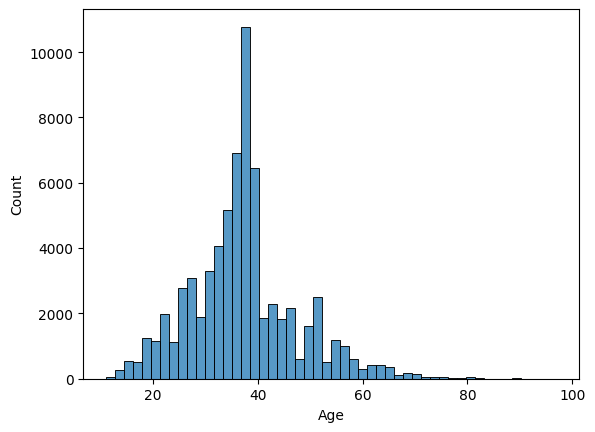

In [43]:
sns.histplot(data['Age'], bins=50)

In [44]:
X = data.drop(columns=['Book-Rating'])
y = data['Book-Rating']
cat_features = ['Book-Author', 'Location', 'categories']

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model_cat_boost = CatBoostRegressor(loss_function='RMSE', random_state=42)
model_cat_boost.fit(X_train, y_train, cat_features=cat_features, verbose=False)

In [47]:
predictions = model_cat_boost.predict(X_test).tolist()
np.sqrt(mean_squared_error(y_test.tolist(), predictions))

1.5556085982376313

In [48]:
r2_score(y_test.tolist(), predictions)

0.24987144517921445